In [26]:
!pip install tensorflow==2.13
!pip install tensorflow-addons==0.21.0

  Using cached tensorflow-2.13.0-cp310-cp310-macosx_12_0_arm64.whl.metadata (2.6 kB)
  Using cached tensorflow_macos-2.13.0-cp310-cp310-macosx_12_0_arm64.whl.metadata (3.2 kB)
  Using cached gast-0.4.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached numpy-1.24.3-cp310-cp310-macosx_11_0_arm64.whl.metadata (5.6 kB)
  Using cached typing_extensions-4.5.0-py3-none-any.whl.metadata (8.5 kB)
  Using cached tensorboard-2.13.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached tensorflow_estimator-2.13.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached keras-2.13.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl.metadata (2.7 kB)
Using cached tensorflow-2.13.0-cp310-cp310-macosx_12_0_arm64.whl (1.9 kB)
Using cached tensorflow_macos-2.13.0-cp310-cp310-macosx_12_0_arm64.whl (189.3 MB)
Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
Using cached keras-2.13.1-py3-none-any.whl (1.7 MB)
Using cached numpy-1.24.3-cp310-cp310-macosx_11_0_arm64.

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

/Users/sanjana/Desktop/venv3/venv3/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/sanjana/Desktop/venv3/venv3/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not 

In [28]:
num_classes = 10
input_shape = (32,32,3)
import ssl
ssl._create_default_https_context=ssl._create_unverified_context
from tensorflow import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [29]:
x_train = x_train[:500]
y_train = y_train[:500]
x_test = x_test[:100]
x_test = x_test[:100]

In [30]:
x_train.shape

(500, 32, 32, 3)

In [31]:
y_train.shape

(500, 1)

In [32]:
x_test.shape

(100, 32, 32, 3)

In [33]:
y_test.shape

(10000, 1)

In [34]:
#Hyper parameteres definition
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 30
image_size = 72
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 8
mlp_head_units = [2048, 1024]

In [35]:
#buid VIT classifier model
# 1.Data Agumentation

data_agumentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.2),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2)
    ],
    name="data_agumentation",)
data_agumentation.layers[0].adapt(x_train)

2025-09-05 20:35:13.665635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [36]:
# 2. Define MLP architecture

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation = tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [37]:
#patches
class Patches(layers.Layer):
    def __init__(self,patch_size):
       super(Patches,self).__init__()
       self.patch_size = patch_size

    def call(self,images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(images=images, sizes = [1,self.patch_size, self.patch_size,1],
                                          strides=[1, self.patch_size, self.patch_size, 1],rates=[1,1,1,1],
                                          padding = "VALID")
        patch_dim = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dim])
        return patches
    

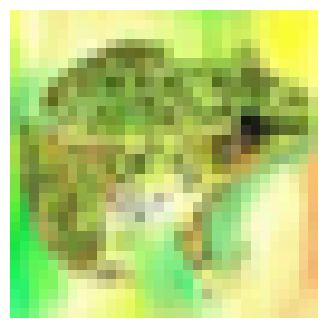

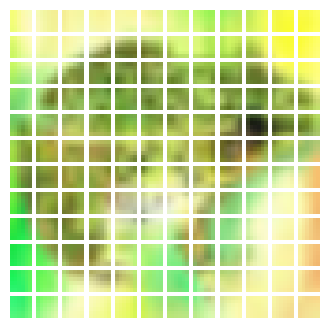

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image)
plt.axis('off')

resized_image = tf.image.resize(tf.convert_to_tensor([image]), size=(image_size,image_size))
patches = Patches(patch_size)(resized_image)

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n,n,i+1)
    patch_imag = tf.reshape(patch, (patch_size,patch_size,3))
    plt.imshow(patch_imag.numpy().astype('uint8'))
    plt.axis('off')

In [39]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder,self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches,output_dim=projection_dim)

    def call(self,patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) +self.position_embedding(positions)
        return encoded

In [40]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    agumentation = data_agumentation(inputs)
    patches = Patches(patch_size)(agumentation)
    encoded_patches = PatchEncoder(num_patches,projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads,key_dim=projection_dim,dropout=0.1)(x1,x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x4 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x4,x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(num_classes)(features)

    model = keras.Model(inputs=inputs, outputs=logits)
    return model
            

In [41]:
def run(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate,weight_decay=weight_decay)

    model.compile(optimizer=optimizer, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics = [keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top_5_accuracy"),],)
    checkpoint_filepath = "./tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor="val_accuracy",
                                                          save_best_only=True, save_weights_only=True)

    history = model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.1,
                        callbacks=[checkpoint_callback],)

    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test Accuracy: {round(accuarcy *100), 2}%")
    print(f"Test top 5 Accuracy: {round(top_5_accuracy *100), 2}%")
    

In [42]:
vit_classifier = create_vit_classifier()
history = run(vit_classifier)

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-09-05 20:43:35.682326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 15s - loss: 4.5728 - accuracy: 0.1094 - top_5_accuracy: 0.5039

2025-09-05 20:43:47.727356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - ETA: 0s - loss: 6.6050 - accuracy: 0.1200 - top_5_accuracy: 0.5311 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x320c1c550> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2/2 [==============================] - 26s 10s/step - loss: 6.6050 - accuracy: 0.1200 - top_5_accuracy: 0.5311 - val_loss: 5.8921 - val_accuracy: 0.1800 - val_top_5_accuracy: 0.6400
Epoch 2/30


2025-09-05 20:43:57.648824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 6s - loss: 7.9014 - accuracy: 0.1758 - top_5_accuracy: 0.5703

2025-09-05 20:44:04.571052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - 13s 6s/step - loss: 7.2040 - accuracy: 0.1578 - top_5_accuracy: 0.5889 - val_loss: 3.2335 - val_accuracy: 0.2800 - val_top_5_accuracy: 0.7200
Epoch 3/30


2025-09-05 20:44:10.642091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 6s - loss: 5.1847 - accuracy: 0.1680 - top_5_accuracy: 0.6406

2025-09-05 20:44:17.088724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - 11s 5s/step - loss: 4.8587 - accuracy: 0.1489 - top_5_accuracy: 0.6200 - val_loss: 2.7238 - val_accuracy: 0.1200 - val_top_5_accuracy: 0.6600
Epoch 4/30


2025-09-05 20:44:21.665681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 5s - loss: 3.2697 - accuracy: 0.1641 - top_5_accuracy: 0.6562

2025-09-05 20:44:27.262908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - 11s 5s/step - loss: 3.2332 - accuracy: 0.1644 - top_5_accuracy: 0.6467 - val_loss: 2.2992 - val_accuracy: 0.3000 - val_top_5_accuracy: 0.6000
Epoch 5/30


2025-09-05 20:44:32.489443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 5s - loss: 2.8972 - accuracy: 0.1680 - top_5_accuracy: 0.6250

2025-09-05 20:44:37.982010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - 10s 5s/step - loss: 2.8342 - accuracy: 0.1800 - top_5_accuracy: 0.6356 - val_loss: 2.2738 - val_accuracy: 0.2000 - val_top_5_accuracy: 0.6400
Epoch 6/30


2025-09-05 20:44:42.580435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 5s - loss: 2.5545 - accuracy: 0.1992 - top_5_accuracy: 0.6719

2025-09-05 20:44:48.137223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - 10s 4s/step - loss: 2.6371 - accuracy: 0.1756 - top_5_accuracy: 0.6533 - val_loss: 2.0673 - val_accuracy: 0.2000 - val_top_5_accuracy: 0.8200
Epoch 7/30


2025-09-05 20:44:52.577657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 5s - loss: 2.5323 - accuracy: 0.1836 - top_5_accuracy: 0.6797

2025-09-05 20:44:58.150319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - 10s 4s/step - loss: 2.4737 - accuracy: 0.1889 - top_5_accuracy: 0.6889 - val_loss: 2.0343 - val_accuracy: 0.1800 - val_top_5_accuracy: 0.7600
Epoch 8/30


2025-09-05 20:45:02.639357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 6s - loss: 2.4778 - accuracy: 0.1953 - top_5_accuracy: 0.6641

2025-09-05 20:45:09.138797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - 12s 5s/step - loss: 2.4323 - accuracy: 0.1822 - top_5_accuracy: 0.6911 - val_loss: 2.0622 - val_accuracy: 0.2400 - val_top_5_accuracy: 0.7600
Epoch 9/30


2025-09-05 20:45:14.145473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 6s - loss: 2.3904 - accuracy: 0.2344 - top_5_accuracy: 0.7227

2025-09-05 20:45:20.250042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - 11s 5s/step - loss: 2.3743 - accuracy: 0.2244 - top_5_accuracy: 0.7067 - val_loss: 1.9812 - val_accuracy: 0.2400 - val_top_5_accuracy: 0.7800
Epoch 10/30


2025-09-05 20:45:24.894389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 6s - loss: 2.3121 - accuracy: 0.2109 - top_5_accuracy: 0.7422

2025-09-05 20:45:31.135802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - 11s 5s/step - loss: 2.2948 - accuracy: 0.2200 - top_5_accuracy: 0.7444 - val_loss: 1.9350 - val_accuracy: 0.2200 - val_top_5_accuracy: 0.7400
Epoch 11/30


2025-09-05 20:45:35.772021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 5s - loss: 2.1877 - accuracy: 0.2773 - top_5_accuracy: 0.7344

2025-09-05 20:45:41.618671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - 11s 5s/step - loss: 2.2554 - accuracy: 0.2400 - top_5_accuracy: 0.7311 - val_loss: 1.9429 - val_accuracy: 0.2400 - val_top_5_accuracy: 0.8000
Epoch 12/30


2025-09-05 20:45:46.404444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 6s - loss: 2.2336 - accuracy: 0.1953 - top_5_accuracy: 0.7539

2025-09-05 20:45:52.672600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - 11s 5s/step - loss: 2.2257 - accuracy: 0.1822 - top_5_accuracy: 0.7444 - val_loss: 1.9346 - val_accuracy: 0.2400 - val_top_5_accuracy: 0.8200
Epoch 13/30


2025-09-05 20:45:57.295094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 5s - loss: 2.1759 - accuracy: 0.2773 - top_5_accuracy: 0.7422

2025-09-05 20:46:02.836524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - 10s 5s/step - loss: 2.1670 - accuracy: 0.2756 - top_5_accuracy: 0.7467 - val_loss: 1.9316 - val_accuracy: 0.2000 - val_top_5_accuracy: 0.8400
Epoch 14/30


2025-09-05 20:46:07.400355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 5s - loss: 2.1283 - accuracy: 0.2344 - top_5_accuracy: 0.7773

2025-09-05 20:46:12.960935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - 10s 4s/step - loss: 2.0961 - accuracy: 0.2467 - top_5_accuracy: 0.7778 - val_loss: 1.9580 - val_accuracy: 0.1800 - val_top_5_accuracy: 0.8200
Epoch 15/30


2025-09-05 20:46:17.355403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 6s - loss: 1.9847 - accuracy: 0.2617 - top_5_accuracy: 0.7969

2025-09-05 20:46:23.753912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - 11s 5s/step - loss: 2.0323 - accuracy: 0.2756 - top_5_accuracy: 0.7889 - val_loss: 1.9468 - val_accuracy: 0.2200 - val_top_5_accuracy: 0.8200
Epoch 16/30


2025-09-05 20:46:28.356236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 5s - loss: 2.0443 - accuracy: 0.2695 - top_5_accuracy: 0.7734

2025-09-05 20:46:33.857888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - 10s 4s/step - loss: 2.0287 - accuracy: 0.2667 - top_5_accuracy: 0.7978 - val_loss: 1.9534 - val_accuracy: 0.2400 - val_top_5_accuracy: 0.7600
Epoch 17/30


2025-09-05 20:46:38.341323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 5s - loss: 2.0043 - accuracy: 0.3008 - top_5_accuracy: 0.8203

2025-09-05 20:46:43.936994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - 10s 5s/step - loss: 2.0918 - accuracy: 0.2733 - top_5_accuracy: 0.8000 - val_loss: 1.9583 - val_accuracy: 0.2000 - val_top_5_accuracy: 0.7800
Epoch 18/30


2025-09-05 20:46:48.524714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 5s - loss: 1.9711 - accuracy: 0.3008 - top_5_accuracy: 0.8242

2025-09-05 20:46:54.120519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - 10s 4s/step - loss: 2.0108 - accuracy: 0.2978 - top_5_accuracy: 0.8022 - val_loss: 1.9918 - val_accuracy: 0.1800 - val_top_5_accuracy: 0.7400
Epoch 19/30


2025-09-05 20:46:58.605134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 5s - loss: 1.9917 - accuracy: 0.2930 - top_5_accuracy: 0.8320

2025-09-05 20:47:04.291993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - 10s 5s/step - loss: 1.9900 - accuracy: 0.2822 - top_5_accuracy: 0.8067 - val_loss: 1.9703 - val_accuracy: 0.1800 - val_top_5_accuracy: 0.7800
Epoch 20/30


2025-09-05 20:47:09.007437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 5s - loss: 1.8842 - accuracy: 0.3359 - top_5_accuracy: 0.8398

2025-09-05 20:47:14.803014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - 10s 5s/step - loss: 1.9468 - accuracy: 0.3222 - top_5_accuracy: 0.8244 - val_loss: 1.9662 - val_accuracy: 0.1800 - val_top_5_accuracy: 0.8200
Epoch 21/30


2025-09-05 20:47:19.457424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 5s - loss: 1.8729 - accuracy: 0.3438 - top_5_accuracy: 0.8828

2025-09-05 20:47:25.149076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - 10s 4s/step - loss: 1.9225 - accuracy: 0.3267 - top_5_accuracy: 0.8600 - val_loss: 1.9896 - val_accuracy: 0.2200 - val_top_5_accuracy: 0.7400
Epoch 22/30


2025-09-05 20:47:29.626779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 6s - loss: 1.9296 - accuracy: 0.3008 - top_5_accuracy: 0.7969

2025-09-05 20:47:36.146337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - 11s 5s/step - loss: 1.9069 - accuracy: 0.3133 - top_5_accuracy: 0.8178 - val_loss: 1.9811 - val_accuracy: 0.2400 - val_top_5_accuracy: 0.7400
Epoch 23/30


2025-09-05 20:47:40.957899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 5s - loss: 1.9050 - accuracy: 0.3242 - top_5_accuracy: 0.8438

2025-09-05 20:47:46.818680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - 10s 5s/step - loss: 1.8739 - accuracy: 0.3222 - top_5_accuracy: 0.8578 - val_loss: 1.9882 - val_accuracy: 0.2400 - val_top_5_accuracy: 0.8000
Epoch 24/30


2025-09-05 20:47:51.406819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 5s - loss: 1.8700 - accuracy: 0.3711 - top_5_accuracy: 0.8203

2025-09-05 20:47:57.046683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - 10s 5s/step - loss: 1.8994 - accuracy: 0.3356 - top_5_accuracy: 0.8156 - val_loss: 1.9653 - val_accuracy: 0.2800 - val_top_5_accuracy: 0.7400
Epoch 25/30


2025-09-05 20:48:01.796747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 7s - loss: 1.8181 - accuracy: 0.3711 - top_5_accuracy: 0.8555

2025-09-05 20:48:08.966262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - 12s 5s/step - loss: 1.8111 - accuracy: 0.3556 - top_5_accuracy: 0.8444 - val_loss: 1.9640 - val_accuracy: 0.2400 - val_top_5_accuracy: 0.7200
Epoch 26/30


2025-09-05 20:48:13.686154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 5s - loss: 1.7972 - accuracy: 0.3594 - top_5_accuracy: 0.8477

2025-09-05 20:48:19.403292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - 10s 4s/step - loss: 1.8114 - accuracy: 0.3511 - top_5_accuracy: 0.8489 - val_loss: 1.9526 - val_accuracy: 0.2600 - val_top_5_accuracy: 0.7800
Epoch 27/30


2025-09-05 20:48:23.872304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 5s - loss: 1.7840 - accuracy: 0.3672 - top_5_accuracy: 0.8516

2025-09-05 20:48:29.520274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - 10s 5s/step - loss: 1.8159 - accuracy: 0.3467 - top_5_accuracy: 0.8578 - val_loss: 1.9388 - val_accuracy: 0.2800 - val_top_5_accuracy: 0.8200
Epoch 28/30


2025-09-05 20:48:34.099914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 6s - loss: 1.6451 - accuracy: 0.4141 - top_5_accuracy: 0.8398

2025-09-05 20:48:40.494287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - 11s 5s/step - loss: 1.6559 - accuracy: 0.3956 - top_5_accuracy: 0.8644 - val_loss: 1.9255 - val_accuracy: 0.2600 - val_top_5_accuracy: 0.8000
Epoch 29/30


2025-09-05 20:48:45.181545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 5s - loss: 1.7291 - accuracy: 0.3555 - top_5_accuracy: 0.8984

2025-09-05 20:48:50.840355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - 10s 5s/step - loss: 1.6922 - accuracy: 0.3889 - top_5_accuracy: 0.8911 - val_loss: 1.9100 - val_accuracy: 0.2600 - val_top_5_accuracy: 0.8600
Epoch 30/30


2025-09-05 20:48:55.408221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/2 [==============>...............] - ETA: 5s - loss: 1.6702 - accuracy: 0.4141 - top_5_accuracy: 0.8789

2025-09-05 20:49:01.116956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/2 [==============================] - 11s 5s/step - loss: 1.6698 - accuracy: 0.4022 - top_5_accuracy: 0.9000 - val_loss: 1.9323 - val_accuracy: 0.2400 - val_top_5_accuracy: 0.8200


ValueError: Data cardinality is ambiguous:
  x sizes: 100
  y sizes: 10000
Make sure all arrays contain the same number of samples.

In [43]:
class_name = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

In [44]:
def imp_predict(images, model) :

    if len(images.shape) == 3:
        out = model.predict(images)
    prediction = np.argmax(out, axis = 1)
    img_prediction = [class_names[i] for i in prediction]
    return img_prediction

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 32, 32, 3), found shape=(32, 32, 3)

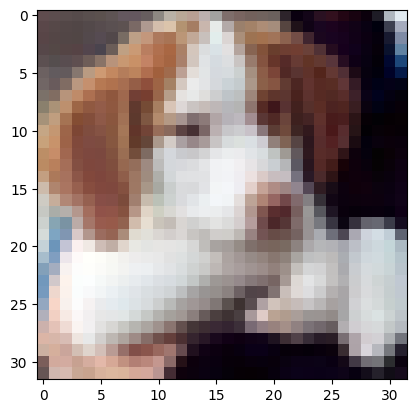

In [47]:
index = 16
plt.imshow(x_test[index])
prediction = imp_predict(x_test[index], vit_classifier)
print(prediction)